In [1]:
# numpy and pandas for data manipulation
import sys
# Suppress warnings
import warnings
import seaborn as sns
import matplotlib as plt
import networkx as nx
import numpy as np
import pandas as pd
import os
import matplotlib2tikz
plt.style.use('seaborn')
sns.set(style="whitegrid")
sns.set_context("paper", font_scale=4, rc={"lines.markersize": 15})
plt.rc('hatch', color='white', linewidth=1)
plt.rcParams.update({
    "font.family": "serif",
     "font.serif": [] ,
      "font.sans-serif": ["Linux Biolinum"]  })

warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline
ROOT_RESULT_FOLDER = '/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/experiment_results/remote'


SYSTEM_COLOR = sns.color_palette()[0]
BASELINE_COLOR = sns.color_palette()[1]

WRITE_DIRECTORY_ROOT = \
'/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/papers/images/experiment-results'

output_directory = WRITE_DIRECTORY_ROOT + '/kaggle_home_credit/materialization'
def create_folder(path):
    if not os.path.exists(os.path.dirname(path)):
        try:
            os.makedirs(os.path.dirname(path))
        except OSError as exc:  # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise

In [2]:
result_folder = ROOT_RESULT_FOLDER + '/materialization/kaggle_home_credit'
result_file = result_folder + '/cloud-41/2019-10-13/22-30.csv'

In [3]:
HEADERS = [
    'timestamp', 'exp_id', 'repo', 'workload', 'mat_type','budget', 'total_mat', 'total_size','run_time'
]
mat_map = {'simple':'HM','storage_aware':'SA'}
materialization_result = pd.read_csv(result_file, header=None, names=HEADERS)
materialization_result['mat_type'] = materialization_result['mat_type'].replace(mat_map)
materialization_result[['budget', 'total_mat', 'total_size']] = materialization_result[['budget', 'total_mat', 'total_size']] / (1024. * 1024.)
materialization_result = materialization_result[materialization_result.budget!=0]

In [4]:
def plot_execution_time(df, loc=None):
    cat = sns.catplot(
        data=df,
        x='budget',
        y='run_time',
        hue='mat_type',
        kind ='bar',
        ci=99,
        hue_order=['HM', 'SA'],
        palette={
            'SA': SYSTEM_COLOR,
            'HM': BASELINE_COLOR
        },
        legend=False)
    #top = df['run_time'].max()
    #cat.set_axis_labels('Execution Number', 'Run Time (s)')
    cat.set_xlabels('Budget (GB)', fontsize=32)
    cat.set_ylabels('Total Run Time (s)', fontsize=32)
    
    #cat.set(ylim=(0, top + 100))
    plt.tick_params(axis = 'x',labelsize = 28, rotation=90)
    
    budgets = len(df.budget.unique())
    for i, bar in enumerate(cat.ax.patches):
        if i < budgets:
            h = '/'
        else:
            h = 'x'
        bar.set_edgecolor('lightgray')
        bar.set_hatch(h)
        
    lg = plt.legend(loc='upper center', fontsize=28, ncol = 2, columnspacing=-1, bbox_to_anchor=(0.48,1.15))
    lg.legendHandles[0].xy = (45,0)
    lg.legendHandles[1].xy = (45,0)
    lg.legendHandles[0]._width = 31
    lg.legendHandles[1]._width = 31

    if loc is not None:
        cat.savefig(loc, bbox_inches ='tight')

In [17]:
materialization_result[materialization_result.budget == 8]

,timestamp,exp_id,repo,workload,mat_type,budget,total_mat,total_size,run_time
16,20:30:33,2ABF01AC,kaggle_home_credit,start_here_a_gentle_introduction,SA,8.0,14.528813,14.528828,199.514472
17,20:30:33,2ABF01AC,kaggle_home_credit,introduction_to_manual_feature_engineering,SA,8.0,38.486259,38.954412,170.843399
18,20:30:33,2ABF01AC,kaggle_home_credit,introduction_to_manual_feature_engineering_p2,SA,8.0,36.238424,121.932056,292.782542
19,20:30:33,2ABF01AC,kaggle_home_credit,fork_cridata_start_here_a_gentle_introduction,SA,8.0,38.464477,121.933067,61.462540
20,20:30:33,2ABF01AC,kaggle_home_credit,fork_taozhongxiao_start_here_a_gentle_introduc...,SA,8.0,44.122528,127.591118,39.714032
21,20:30:33,2ABF01AC,kaggle_home_credit,fork_introduction_to_manual_feature_engineering,SA,8.0,51.464035,127.594321,29.468267
22,20:30:33,2ABF01AC,kaggle_home_credit,fork_introduction_to_manual_feature_engineerin...,SA,8.0,63.927293,127.594321,112.780258
23,20:30:33,2ABF01AC,kaggle_home_credit,fork_join_start_here_intro,SA,8.0,64.389331,128.056359,63.397431
24,21:21:55,1DE5876F,kaggle_home_credit,start_here_a_gentle_introduction,HM,8.0,8.472986,14.528828,199.361111
25,21:21:55,1DE5876F,kaggle_home_credit,introduction_to_manual_feature_engineering,HM,8.0,10.494366,38.954412,171.872691


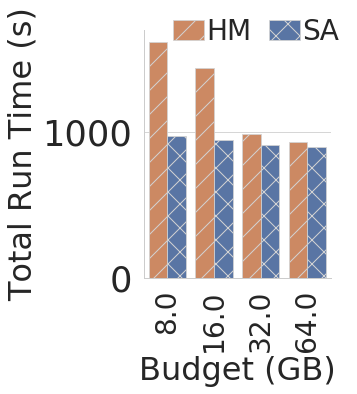

In [13]:
df = materialization_result.groupby(['exp_id','mat_type','budget'])['run_time'].sum().reset_index()
plot_execution_time(df, output_directory+'/run-time.pgf')
#plot_execution_time(df)

In [6]:
def plot_sizes(df, loc=None):
    plt.figure(figsize=(7, 4))
    plot = sns.lineplot(
        data=df,
        x='workload_order',
        y='total_mat',
        hue='mat_type',
        style='mat_type',
        markers=["^", "o"],
        lw=3,
        hue_order=['HM', 'SA'],
        dashes=[(2, 2), (1, 0)],
        palette={
            'SA': SYSTEM_COLOR,
            'HM': BASELINE_COLOR
        },
        legend='brief')

    legend = plt.legend(
        loc='upper left',
        fontsize=38,
        handlelength=1.2,
        handletextpad=0.1,
        labelspacing=-.1,
        bbox_to_anchor=(-.08, 1.25))
    #     legend.legendHandles[0].xy = (1000,0)
    #     legend.legendHandles[1].xy = (60,0)
    #     legend.legendHandles[0]._width = 1
    #     legend.legendHandles[1]._width = 31
    plot.set_ylim((0, 140))
    legend.texts[0].set_text("")
    for line in legend.get_lines():
        line.set_linewidth(3.0)
    plot.set_xlabel('Workload', fontsize=38)
    plot.set_ylabel('Size (GB)', fontsize=38)
    plt.tick_params(labelsize=36)
    plot.set_xticklabels(range(1, 9))
    plot.set_xticks(range(1, 9))
    if loc is not None:
        plt.savefig(loc, bbox_inches='tight')

In [7]:
execution_order = {
    'start_here_a_gentle_introduction': 1,
    'introduction_to_manual_feature_engineering': 2,
    'introduction_to_manual_feature_engineering_p2': 3,
    'fork_cridata_start_here_a_gentle_introduction': 4,
    'fork_taozhongxiao_start_here_a_gentle_introduction': 5,
    'fork_introduction_to_manual_feature_engineering': 6,
    'fork_introduction_to_manual_feature_engineering_p2': 7,
    'fork_join_start_here_intro': 8
}
df = materialization_result[['exp_id','workload','mat_type','budget','total_mat','total_size']]
df['workload_order'] = df['workload'].replace(execution_order)

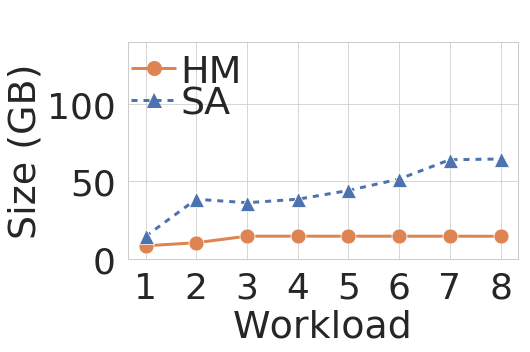

In [8]:
plot_sizes(df[df['budget'] == 8.0], output_directory+'/size-8.pgf')
#plot_sizes(df[df['budget'] == 8.0])

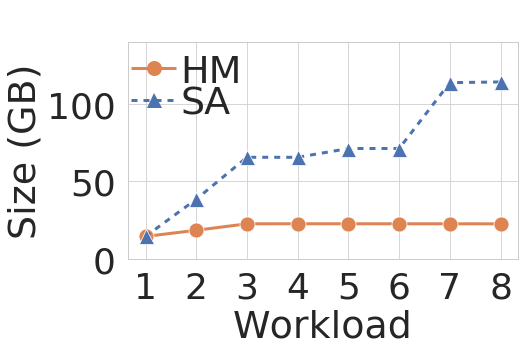

In [9]:
plot_sizes(df[df['budget'] == 16.0], output_directory+'/size-16.pgf')
#plot_sizes(df[df['budget'] == 16.0])

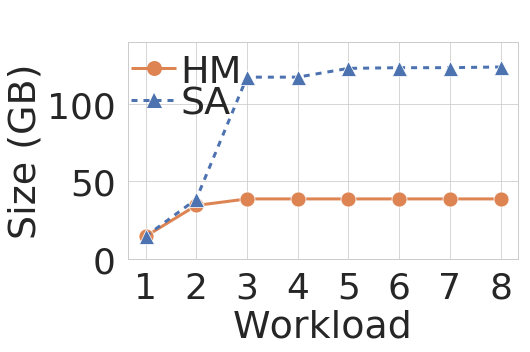

In [10]:
plot_sizes(df[df['budget'] == 32.0], output_directory+'/size-32.pgf')
#plot_sizes(df[df['budget'] == 32.0])

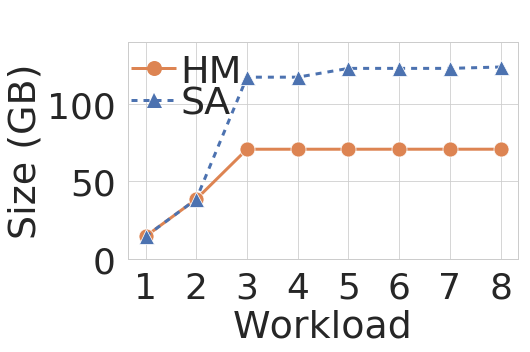

In [12]:
plot_sizes(df[df['budget'] == 64.0], output_directory+'/size-64.pgf')
#plot_sizes(df[df['budget'] == 64.0])